In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import h5py
import api as pyq 
import concurrent.futures

In [3]:
# Wavefunction generation

from scf_runs import run_lda_he, run_lda_li, run_lda_be, run_lda_b, run_lda_c, run_lda_n
scf_checkfile, opt_checkfile, mf_lda = run_lda_li()

/Users/ksu/Documents/GitHub/pyqmc/pyqmc/api.py
/Users/ksu/Software/anaconda3/lib/python3.11/site-packages/pyscf/__init__.py
Li atom neutral LDA spin=1
HF
converged SCF energy = -7.43242052759577  <S^2> = 0.75000054  2S+1 = 2.0000005
LDA
converged SCF energy = -7.34133592929817  <S^2> = 0.75000178  2S+1 = 2.0000018


In [7]:
import importlib, recipes, linemin, sample_many
modules = [recipes, linemin, sample_many]
for m in modules:
    importlib.reload(m)


for fname in ['sj.hdf5']:
    if os.path.isfile(fname):
        os.remove(fname)
print("RUNNING VMC OPTIMIZATION")
ncore = 16

with concurrent.futures.ProcessPoolExecutor(max_workers=ncore) as client:
    recipes.OPTIMIZE(scf_checkfile, "sj.hdf5", 
                     max_iterations=6, 
                     nconfig=1000, 
                     verbose=True,
                     client = client, 
                     npartitions=ncore,                            
                     # jastrow_kws={"ion_cusp":False}
                    )

# Jastrow optimization results
df = recipes.read_opt("sj.hdf5")

# with h5py.File("sj.hdf5") as f:
#     print("keys", list(f.keys()))
#     print("wave function parameters", list(f['wf'].keys()))
#     ee_j = f['energy'][...]   
#     x = f['x'][...]
#     yfit = f['yfit'][...]
#     # pgrad = f['pgradient'][...]   
#     print(f['wf/wf2acoeff'][()])
#     print(f['wf/wf2bcoeff'][()])



RUNNING VMC OPTIMIZATION
starting warmup
finished warmup
----------vmc done
Gradient norm:  1.9145194204748097
Dot product between gradient and SR step:  0.9169767689369622
descent en -7.049972301861374 0.05330699459952939
energies from correlated sampling [-5.95374352 -7.34737659 -7.58771789 -7.24775987 -6.68883214]
----------vmc done
Gradient norm:  0.161648855518632
Dot product between gradient and SR step:  0.9662992361554649
descent en -7.420131800677714 0.036116225375516564
energies from correlated sampling [-7.37951725 -7.41026922 -7.43665033 -7.45832269 -7.47492874]
----------vmc done
Gradient norm:  0.24437206571785944
Dot product between gradient and SR step:  0.9590234888180924
descent en -7.477499694667155 0.020269540196863833
energies from correlated sampling [-7.48747608 -7.51271058 -7.52547668 -7.52568373 -7.51321132]
----------vmc done
Gradient norm:  0.22931967887482552
Dot product between gradient and SR step:  0.929563762366399
descent en -7.5716905822734635 0.028514

In [8]:
df

,energy,iteration,error,fname
0,-7.049972,0,0.053307,sj.hdf5
1,-7.420132,1,0.036116,sj.hdf5
2,-7.477500,2,0.020270,sj.hdf5
3,-7.571691,3,0.028514,sj.hdf5
4,-7.646511,4,0.024293,sj.hdf5
5,-7.565698,5,0.063451,sj.hdf5


In [6]:
import wftools, bosonrecipes, bosonaccumulators, bosonslater, linemin, accumulators, bosonwftools,mc, boson_stochastic_reconfiguration, bosonenergy
modules = [bosonrecipes,wftools, bosonaccumulators, bosonslater, linemin, accumulators, bosonwftools,mc, boson_stochastic_reconfiguration, bosonenergy]
for m in modules:
    importlib.reload(m)

# Boson Jastrow optimizationn
abvmc_file = 'abvmc-j-he_single.hdf5'
for fname in [abvmc_file]:
    if os.path.isfile(fname):
        os.remove(fname)
print("RUNNING ABVMC OPTIMIZATION")

nblocks = 100
nsteps_per_block = 10
tstep=0.3
nconfig=1000
with concurrent.futures.ProcessPoolExecutor(max_workers=ncore) as client:
    bosonrecipes.ABOPTIMIZE(scf_checkfile, 
                      abvmc_file, 
                      max_iterations=6, 
                      verbose=True,  
                      # nblocks=nblocks, 
                      # nsteps_per_block=nsteps_per_block,
                      # tstep= tstep, 
                      # jastrow_kws={"ion_cusp":False},
                      client = client, 
                      npartitions=ncore,                             
                      nconfig=nconfig)
recipes.read_opt(abvmc_file)

RUNNING ABVMC OPTIMIZATION
Using spherical guess
starting warmup
finished warmup
-

PicklingError: Can't pickle <class 'boson_stochastic_reconfiguration.BosonStochasticReconfiguration'>: it's not the same object as boson_stochastic_reconfiguration.BosonStochasticReconfiguration

In [ ]:
with h5py.File(abvmc_file) as f:
    print("keys", list(f.keys()))
    print("wave function parameters", list(f['wf'].keys()))
    ee_j = f['energy'][...]   
    x = f['x'][...]
    yfit = f['yfit'][...]
    # pgrad = f['pgradient'][...]   
    print(f['wf/wf2acoeff'][()])
    print(f['wf/wf2bcoeff'][()])

import matplotlib.pyplot as plt
plt.plot(yfit, marker='o', label="etot")


Text(0, 0.5, 'Partial gradients')

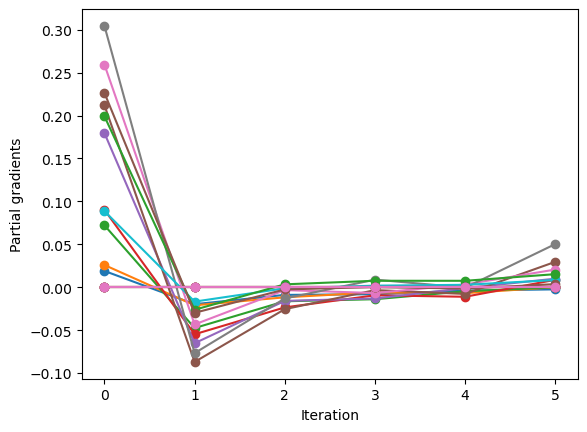

In [15]:
f = h5py.File(abvmc_file)
aa=f['pgrad'][...]
import matplotlib.pyplot as plt
plt.plot(aa, marker='o', label="etot")
plt.xlabel('Iteration')
plt.ylabel('Partial gradients')

In [175]:
# def get_variance(df, 
#                  discard = 10):
#     keys = df.keys()
#     numblocks = df[keys[0]].shape[0]
#     num_used_blocks = numblocks - discard
#     print('\t\t\t{:10s} {:6s} {:3s}'.format('Mean', 'Var', 'Ratio'))
#     for k in keys:
#         eb = df[k][discard:]
#         mean = np.mean(eb)
#         var = np.sqrt(1/(num_used_blocks - 1 ) * np.sum(eb**2 - mean**2))
#         print('{} \t {:.6f} \t {:.6f} {:.3f}'.format(k, mean, var, np.abs(var/mean)))

In [30]:
# get_variance(bosonrecipes.read_abvmc("bosonvmc.hdf5"),
#             discard=0)
# df2 = bosonrecipes.read_abvmc("bosonvmc.hdf5")
# df2
# plt.plot(df2['energytotal'], '-o', label='tot')
# # plt.plot(df2['energyei'], label='ei')
# # plt.plot(df2['energyee'], label='ee')
# # plt.plot(df2['energyke'], label='ke')
# # plt.plot(df2['energyvxc'], label='vxc')
# # plt.axhline(y=0, linestyle='dashed')
# plt.legend()

In [17]:
import importlib, recipes, bosonrecipes, bosonslater, bosonaccumulators, bosonwftools 
modules = [recipes, bosonrecipes, bosonrecipes, bosonslater, bosonaccumulators, bosonwftools] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)

# Boson Jastrow optimizationn
    
for fname in ['bosonsjnoi.hdf5']:
    if os.path.isfile(fname):
        os.remove(fname)
print("RUNNING ABVMC OPTIMIZATION NO ION CUSP")
wf, df = bosonrecipes.ABOPTIMIZE(scf_checkfile, "bosonsjnoi.hdf5", max_iterations=24, nconfig=1000, verbose=True,
                                jastrow_kws={"ion_cusp":False}
                                )

# Jastrow optimization results
dfnoi = pyq.read_opt("bosonsjnoi.hdf5")
dfnoi



RUNNING ABVMC OPTIMIZATION NO ION CUSP
Number of determinants in the bosonic wavefunction= 1
Using spherical guess
starting warmup
finished warmup
----------vmc done
Gradient norm:  0.1453199792541806
Dot product between gradient and SR step:  0.9784617716604322
descent en -2.8666383753081197 0.0013890246203200724
energies from correlated sampling [-2.79603046 -2.82335953 -2.84618373 -2.86489457 -2.87984999]
----------vmc done
Gradient norm:  0.04944151437772344
Dot product between gradient and SR step:  0.9877517491069976
descent en -2.8891615788326606 0.0016532874021162169
energies from correlated sampling [-2.87774984 -2.87969227 -2.88151087 -2.88320591 -2.88477768]
----------vmc done
Gradient norm:  0.031107552629770007
Dot product between gradient and SR step:  0.9888479405707269
descent en -2.889596875293664 0.001612251778042078
energies from correlated sampling [-2.87433707 -2.87568714 -2.87697399 -2.87819816 -2.87936013]
----------vmc done
Gradient norm:  0.02843026307168962
Do

,energy,iteration,error,fname
0,-2.866638,0,0.001389,bosonsjnoi.hdf5
1,-2.889162,1,0.001653,bosonsjnoi.hdf5
2,-2.889597,2,0.001612,bosonsjnoi.hdf5
3,-2.886646,3,0.001079,bosonsjnoi.hdf5
4,-2.889349,4,0.000861,bosonsjnoi.hdf5
5,-2.889454,5,0.001528,bosonsjnoi.hdf5
6,-2.891159,6,0.001383,bosonsjnoi.hdf5
7,-2.893427,7,0.000784,bosonsjnoi.hdf5
8,-2.890395,8,0.001207,bosonsjnoi.hdf5
9,-2.890467,9,0.001246,bosonsjnoi.hdf5


keys ['SRdot', 'configs', 'energy', 'energy_error', 'est_min', 'iteration', 'nconfig', 'pgrad', 'tau', 'wf', 'x', 'yfit']
wave function parameters ['wf2acoeff', 'wf2bcoeff']
[[[ 0.14807857  0.14986633]
  [ 0.22169254  0.22336089]
  [ 0.06112087  0.06198473]
  [-0.04934876 -0.04688615]]]
[[-0.25       -0.5        -0.25      ]
 [ 0.         -0.06997235  0.        ]
 [ 0.         -0.26191307  0.        ]
 [ 0.         -0.15962388  0.        ]]


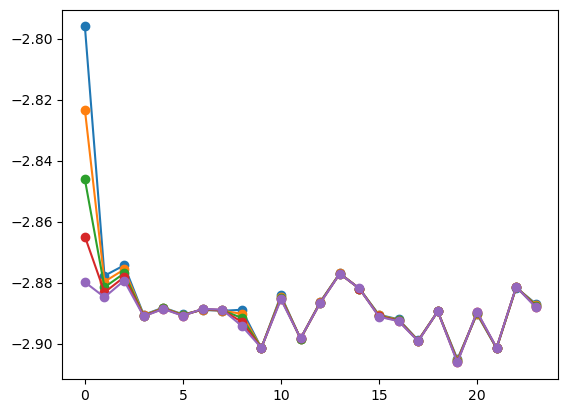

In [24]:
with h5py.File("bosonsjnoi.hdf5") as f:
    print("keys", list(f.keys()))
    print("wave function parameters", list(f['wf'].keys()))
    ee_j = f['energy'][...]   
    x = f['x'][...]
    yfit = f['yfit'][...]
    pgrad = f['pgrad'][...]   
    print(f['wf/wf2acoeff'][()])
    print(f['wf/wf2bcoeff'][()])

import matplotlib.pyplot as plt
plt.plot(yfit, marker='o', label="etot")


In [25]:
# f = h5py.File("bosonsjnoi.hdf5")
# aa=f['params'][...]
# import matplotlib.pyplot as plt
# plt.plot(aa, marker='o', label="etot")
# plt.xlabel('Iteration')
# plt.ylabel('Value of Jastrow parameters')